# Specreduce Workflow Exploration
Based (initially) on the `pydis` machinery built by @jradavenport in 2015. All `pydis` pieces (or others as we swap-out, build-up, etc) will be moved flatly into this directory instead of importing for now.

Goal is to complete basic full reduction, illustrating a typical workflow, and then facilitate discussion about API and design choices for `specreduce` and it's interface with `ccdproc` and `specutils` (and others).

Also, look for opportunities to generalize what *observatories* or specific instruments could provide (e.g. trace templates as astropy models, reference cals as frist-guesses or fallbacks) to make reduction guides or even quick-look autoreductions.

**Put LOTS of comments and markdown discussion in!**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# Imports for SPECREDUCE stuff
from astropy.io import fits

## The Data


In [4]:
dir = 'apo05/'

blist = 'biaslist.txt' # list of bias exposures, full path to .fits images
flist = 'flatlist.txt' # list of flat lamp exposures

objs = 'objlist.txt' # list of science objects - only "Gl 669A" in this case
sci = dir + '05may31.0010r.fits' # or in this case, just the 1 object, ignore the list

fstar = 'bd282411' # Flux Calibration Standard Star
fcal = dir + '05may31.0020r.fits' # Flux Cal observation

lamp = dir + '05may31.0035r.fits' # HeNeAr lamp

In [5]:
np.loadtxt(blist, dtype=np.str)

array(['apo05/05may31.0022r.fits', 'apo05/05may31.0023r.fits',
       'apo05/05may31.0024r.fits', 'apo05/05may31.0025r.fits',
       'apo05/05may31.0026r.fits', 'apo05/05may31.0027r.fits',
       'apo05/05may31.0028r.fits', 'apo05/05may31.0029r.fits',
       'apo05/05may31.0030r.fits', 'apo05/05may31.0031r.fits'],
      dtype='<U24')

## CCDProc stuff

The basic reduction pipeline starts with making general FLAT and BIAS images to use throughout. This needs to be converted to `ccdproc`

In [6]:
from pydis import biascombine

bias_im = biascombine(blist, silent=False)

biascombine: combining 10 files in biaslist.txt


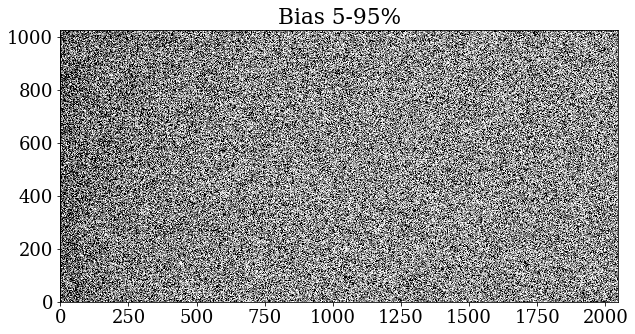

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(bias_im, cmap=plt.cm.Greys, origin='lower', aspect='auto')
plt.clim(np.percentile(bias_im, (5, 95)))
plt.title('Bias 5-95%')
plt.show()

In [8]:
from pydis import flatcombine

# median combine flats, subtracting off the bias
flat_im, ilum = flatcombine(flist, bias_im, display=False, response=True)

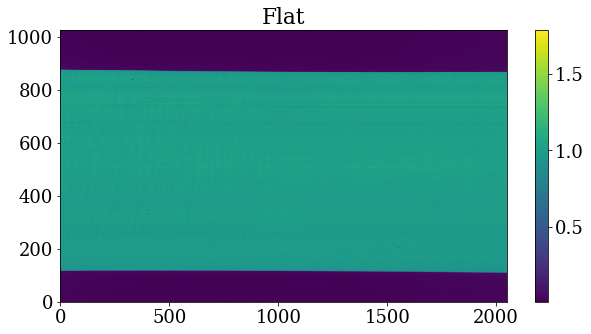

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(flat_im, origin='lower', aspect='auto')
plt.title('Flat')
plt.colorbar()
plt.show()

In [10]:
flat_im[ilum,:].mean()

1.0008718931375815

## Trace the data

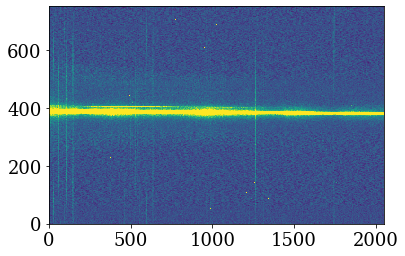

In [11]:
# read the science data (1 image in this case)
# and the flux calibration. Trace may be slightly different

## SCIENCE TARGET (Gl 669A)
sci_hdu = fits.open(sci)
# trim data down from overscan regions
datasec = sci_hdu[0].header['DATASEC'][1:-1].replace(':',',').split(',')
d = list(map(int, datasec))
gl669a = sci_hdu[0].data[d[2]-1:d[3],d[0]-1:d[1]]

exptime = sci_hdu[0].header['EXPTIME']

# BASIC flat & bias removal, and put into (Counts / Seconds) units
sci_im = (gl669a - bias_im)/flat_im / exptime

plt.imshow(sci_im[ilum,:], origin='lower', aspect='auto')
plt.clim(np.percentile(sci_im[ilum,:], (0, 98)))
plt.show()


## FLUX STD
std_hdu = fits.open(fcal)
# trim data down from overscan regions
datasec = std_hdu[0].header['DATASEC'][1:-1].replace(':',',').split(',')
d = list(map(int, datasec))
fluxcal = std_hdu[0].data[d[2]-1:d[3],d[0]-1:d[1]]

exptime = std_hdu[0].header['EXPTIME']
std_im = (fluxcal - bias_im)/flat_im / exptime


Tracing Aperture using nsteps=9
> Trace gaussian width = 2.8603778050636754 pixels


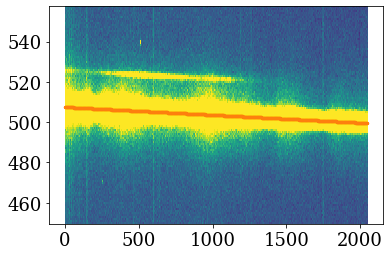

In [12]:
from pydis import ap_trace

# currently finds average peak in Nsteps positions along wavelength axis
# then runs a cubic spline - make polynomial possible? Be smarter, fit for convergence? Use a GP?
sci_trace = ap_trace(sci_im, fmask=ilum, nsteps=9)

plt.imshow(sci_im, origin='lower', aspect='auto')
plt.clim(np.percentile(sci_im[ilum,:], (0, 98)))
plt.scatter(np.arange(len(sci_trace)), sci_trace, s=5, color='C1', alpha=0.5)
plt.ylim(sci_trace.min()-50, sci_trace.max()+50)
plt.show()

Tracing Aperture using nsteps=9
> Trace gaussian width = 2.9565867059426436 pixels


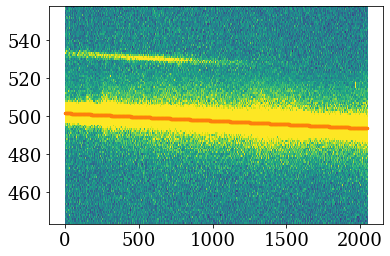

In [13]:
std_trace = ap_trace(std_im, fmask=ilum, nsteps=9)

plt.imshow(std_im, origin='lower', aspect='auto')
plt.clim(np.percentile(std_im[ilum,:], (0, 98)))
plt.scatter(np.arange(len(std_trace)), std_trace, s=5, color='C1', alpha=0.5)
plt.ylim(std_trace.min()-50, sci_trace.max()+50)
plt.show()

## Rough Wavelength
The header has a very bad approximation included

Assume here the camera *thinks* it's stable, and so only compute this using the science image

In [14]:
# simple linear wavelength solution in this case

disp_approx = sci_hdu[0].header['DISPDW']
wcen_approx = sci_hdu[0].header['DISPWC']
# the red chip wavelength is backwards (DIS specific)
clr = sci_hdu[0].header['DETECTOR']
if (clr.lower()=='red'):
    sign = -1.0
else:
    sign = 1.0
    
# put middle of pixels onto wavelength grid (NOT sure, might be edges of pixels..)
wapprox = (np.arange(sci_im.shape[1]) - (sci_im.shape[1])/2.0) * disp_approx * sign + wcen_approx


## Extract the Trace

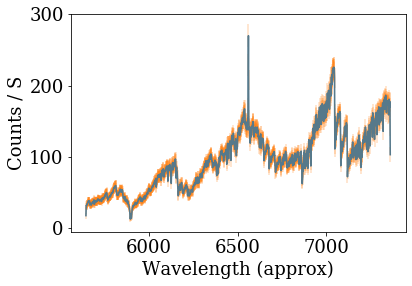

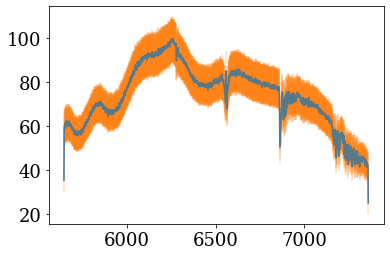

In [15]:
from pydis import ap_extract
# this is basically aperture photometry on each pixel along the trace
# right now does the worst thing, using "sky" chosen +/- about the aperture in pixel space

# SHOULD do: solve for wavelength solution FIRST across whole chip, transform/interpolate image into wavelength,
# then extract w/ sky in region of constant wavelength

# for clarity: writing the default values in for aperture & sky regions
flux_sci, sky_sci, ferr_sci = ap_extract(sci_im, sci_trace, apwidth=8, skysep=3, skywidth=7)
plt.plot(wapprox, flux_sci - sky_sci)
plt.errorbar(wapprox, flux_sci - sky_sci, yerr=ferr_sci, alpha=0.25)
plt.xlabel('Wavelength (approx)')
plt.ylabel('Counts / S')
plt.show()

flux_std, sky_std, ferr_std = ap_extract(std_im, std_trace)
plt.plot(wapprox, flux_std - sky_std)
plt.errorbar(wapprox, flux_std - sky_std, yerr=ferr_std, alpha=0.25)
plt.show()

## Wavelength Calibration
A thing of great concern and debate...

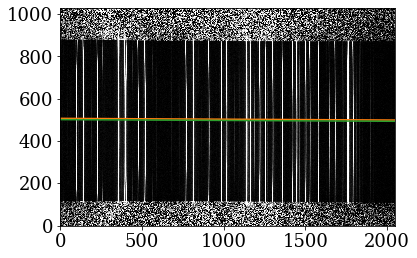

In [16]:
lamp_hdu = fits.open(lamp)
# trim data down from overscan regions
datasec = lamp_hdu[0].header['DATASEC'][1:-1].replace(':',',').split(',')
d = list(map(int, datasec))
henear = lamp_hdu[0].data[d[2]-1:d[3],d[0]-1:d[1]]

exptime = lamp_hdu[0].header['EXPTIME']

# reduction probably not needed w/ the HeNeAr lamps, but might as well
lamp_im = (henear - bias_im)/flat_im / exptime

plt.imshow(lamp_im, origin='lower', aspect='auto', cmap=plt.cm.Greys_r)
plt.clim(np.percentile(lamp_im[ilum,:], (5, 95)))
plt.plot(sci_trace, c='C1')
plt.plot(std_trace, c='C2')
plt.show()


(330, 450)

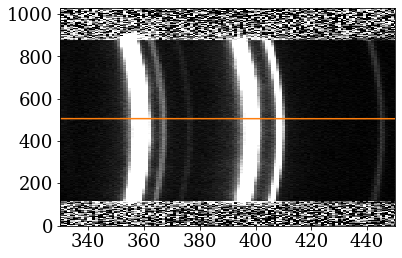

In [17]:
plt.imshow(lamp_im, origin='lower', aspect='auto', cmap=plt.cm.Greys_r)
plt.clim(np.percentile(lamp_im[ilum,:], (5, 95)))
plt.plot(sci_trace, c='C1')
plt.xlim(330,450)

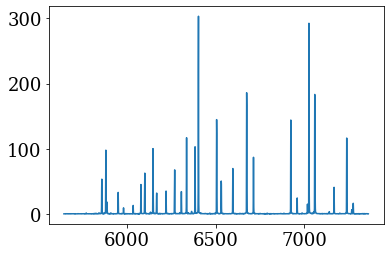

In [18]:
# Approx extract the lamp using the science trace
# I couldn't figure out how to make this a straight array operation w/ numpy alone.
# It could probably be re-cast as a Lambda for more elegance...
lamp_sci = np.zeros_like(sci_trace)
for k in range(sci_trace.size):
    lamp_sci[k] = lamp_im[np.array(sci_trace, dtype=np.int)[k], k]

plt.plot(wapprox, lamp_sci)

Now we need either:

- A) an annoying bit of GUI to pick lines and match to a reference catalog, or
- B) a clever way to use a line list to automagically solve this

I'll pretend this *isn't* a huge problem (and opportunity), and just use a list of lines I've previously identified (w/ a couple errors in there).

In [19]:
from astropy.io import ascii

lines = ascii.read('05may31.0035r.fits.lines', delimiter=',', names=('pixel','wavelength'))

lines.sort('pixel')
# plt.scatter(lines['pixel'], lines['wavelength'])

(-1, 6)

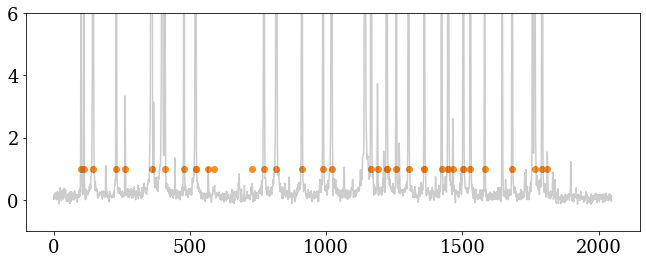

In [20]:
plt.figure(figsize=(11,4))
plt.plot(np.arange(lamp_sci.size), lamp_sci, alpha=0.2, c='k')
plt.scatter(lines['pixel'], np.ones_like(lines['pixel']), alpha=0.86, c='C1')
plt.ylim(-1,6)

(5500, 7800)

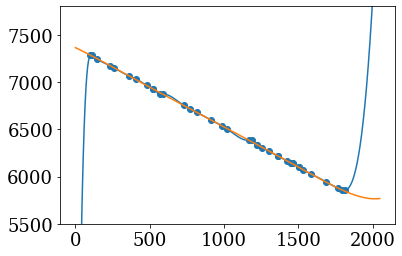

In [21]:
# interpolating the wavelength: here too we need either some GUI or some very clever choices
# I think Adrian P-W used a GP well here... 
# the polynomial (2nd choice, orange line) works better in this example

from scipy.interpolate import UnivariateSpline

Wsoln = UnivariateSpline(lines['pixel'], lines['wavelength'], ext=0, k=3)

# interpolate the spline to 1 position per column
wave_sci = Wsoln( np.arange(0, sci_trace.size) )

plt.scatter(lines['pixel'], lines['wavelength'])
plt.plot(np.arange(sci_trace.size), wave_sci)

K = 7
Wsoln = np.polyfit(lines['pixel'], lines['wavelength'], K)
wave_sci = np.polyval(Wsoln, np.arange(sci_trace.size))
plt.plot(np.arange(sci_trace.size), wave_sci)

plt.ylim(5500,7800)

Text(0, 0.5, 'Counts / S')

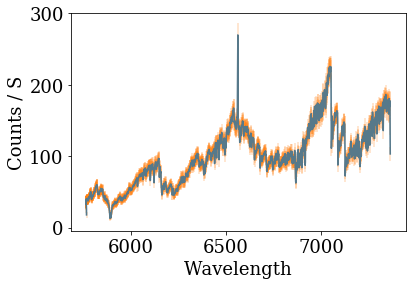

In [22]:
plt.plot(wave_sci, flux_sci - sky_sci)
plt.errorbar(wave_sci, flux_sci - sky_sci, yerr=ferr_sci, alpha=0.25)
plt.xlabel('Wavelength')
plt.ylabel('Counts / S')

(6500, 6600)

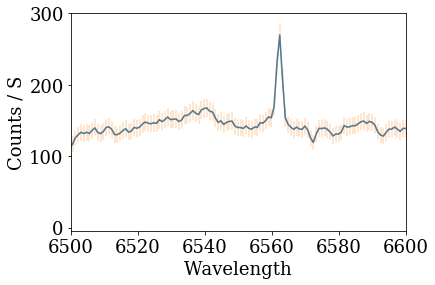

In [23]:
plt.plot(wave_sci, flux_sci - sky_sci)
plt.errorbar(wave_sci, flux_sci - sky_sci, yerr=ferr_sci, alpha=0.25)
plt.xlabel('Wavelength')
plt.ylabel('Counts / S')
plt.xlim(6500,6600)

Still to do:

- actually map the trace for each spectrum (science & standard star) through the HeNeAr to get individual wavelength calibration


## Airmass Correction

In [24]:
from pydis import AirmassCor

# like with the 1D Stds, the observatory airmass corrections are a useful reference library we need
ext_file = './apoextinct.dat'


# DIS doesn't have airmass in header... ugh
# airmass = sci_hdu[0].header['AIRMASS']

ZD = sci_hdu[0].header['ZD'] / 180.0 * np.pi
airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

print(airmass)

1.0668455410852924


In [25]:
flux_sci_x = AirmassCor(wave_sci, flux_sci - sky_sci, airmass,
                        airmass_file=ext_file, path=True)

> Loading airmass library file: ./apoextinct.dat


## Flux Calibration
There's a valuable IRAF library - and others - that we should be packaging as supplemental downloads

My PyDIS function normally knows where the IRAF standards live, but I'm pointing to it locally for reference/discussion

In [26]:
stdstar_file = './bd284211.dat'

(To me) there's conceptually 2 steps to flux calibration:

- 1) Define the Sensitivity Function
- 2) Apply the SensFunc to the data

Step 1 actually has sub-steps, including: 
- masking out bad portions of the std star raw spectrum (i.e. atmos lines, Balmer lines, etc), 
- interpolating down to the same wavelength grid as the refernece spec, 
- dividing the two (i.e. defining the SensFunc),
- interpolating the SensFunc back up to the original wavelength (maybe could be eliminated by just up-sampling the reference spectrum?)


Also note: the IRAF ref spec are in magnitudes (?!) so need to convert things appropriately...

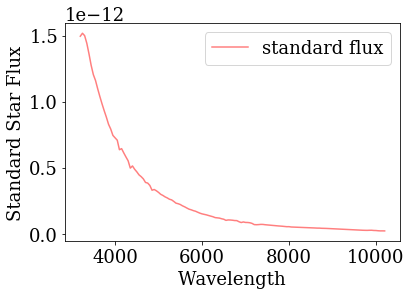

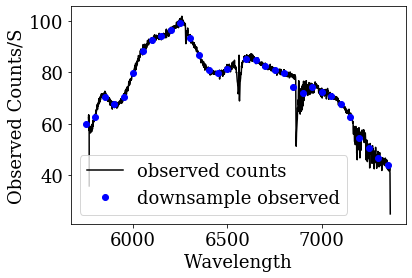

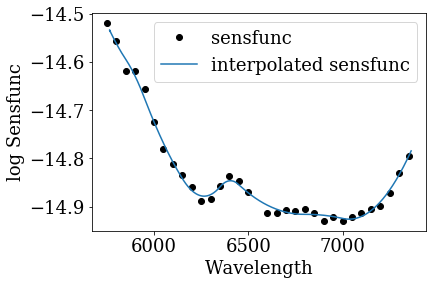

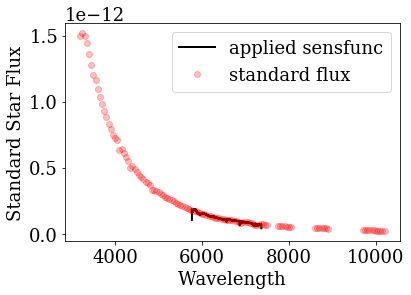

In [27]:
from pydis import DefFluxCal, ApplyFluxCal

# since we're cheating a bit, again assume science & std star have same wavelength solution.
# They're very close, but technically not exactly the same since the trace is slightly offset

# set stdpath=True, since we've defined the full path to the standard star file
sensfunc = DefFluxCal(wave_sci, flux_std, stdstar=stdstar_file, 
                      stdpath = True, display=True, mode='spline')

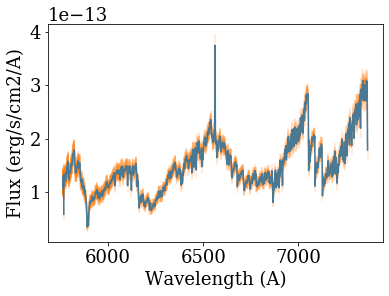

In [28]:
# and now simply apply it - this is a simple multiplication, except 
# double-checking that things are on the same wavelength (does a quick linear interpolation just in case)

ffinal, efinal = ApplyFluxCal(wave_sci, flux_sci_x, ferr_sci, 
                              wave_sci, sensfunc)

plt.plot(wave_sci, ffinal)
plt.errorbar(wave_sci, ffinal, yerr=efinal, alpha=0.2)
plt.xlabel('Wavelength (A)');
plt.ylabel('Flux (erg/s/cm2/A)');